# Artwork Sequence Prediction Evaluation

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

In [2]:
CONFIG_PATH = '/root/work/artwork_sequence/train_test_configuration'

In [3]:
window_index = 3

museum_sequence_path = {
    'x_train' : os.path.join(CONFIG_PATH, 'X_train.csv'),
    'x_test' : os.path.join(CONFIG_PATH, 'X_test.csv'),
    'x_train_matrix' : os.path.join(CONFIG_PATH, 'X_train_matrix.npy'),
    'x_test_matrix' : os.path.join(CONFIG_PATH, 'X_test_matrix.npy'),
    'weights_folder' : os.path.join(CONFIG_PATH, 'config_'+str(window_index)+'/trained_model_weights')
}
museum_sequence_path

{'weights_folder': '/root/work/artwork_sequence/train_test_configuration/config_3/trained_model_weights',
 'x_test': '/root/work/artwork_sequence/train_test_configuration/X_test.csv',
 'x_test_matrix': '/root/work/artwork_sequence/train_test_configuration/X_test_matrix.npy',
 'x_train': '/root/work/artwork_sequence/train_test_configuration/X_train.csv',
 'x_train_matrix': '/root/work/artwork_sequence/train_test_configuration/X_train_matrix.npy'}

## Load data

In [5]:
df_x_train = pd.read_csv(museum_sequence_path['x_train'], index_col=0)
df_x_test = pd.read_csv(museum_sequence_path['x_test'], index_col=0)
x_train_matrix = np.load(museum_sequence_path['x_train_matrix'])
x_test_matrix = np.load(museum_sequence_path['x_test_matrix'])
df_x_train.head()

,tour_path
20,/root/work/datasets/artwork_sequence/rijksmuse...
7,/root/work/datasets/artwork_sequence/rijksmuse...
40,/root/work/datasets/artwork_sequence/prado_cra...
0,/root/work/datasets/artwork_sequence/rijksmuse...
23,/root/work/datasets/artwork_sequence/prado_cra...


In [6]:
x_train_matrix.shape

(637, 300)

In [7]:
df_x_test['tour_path'][39]

'/root/work/datasets/artwork_sequence/prado_crawler/tour_18'

## Reset Tensorflow session

In [8]:
tf.keras.backend.clear_session()

## Config  data to fit with the model input

Because the **Prediction feature model** split the data into training and validation dataset, it is necessary to give all the data in only one block

**Define timeline**

In [9]:
timeline = np.arange(x_train_matrix.shape[0] + x_test_matrix.shape[0])
timeline.shape

(859,)

**Define configuration to deal with the windowed dataset**

In [10]:
split_time = x_train_matrix.shape[0]

X = np.concatenate((x_train_matrix, x_test_matrix))

window_size = window_index

batch_size = 128
shuffle_buffer_size = 300

## Create and Load models

**Helper function to load weights**

In [11]:
def load_weights(model, index, museum_sequence_path):
    #Find the folder where the weights are saved
    model_feature_folder = os.path.join(museum_sequence_path['weights_folder'], 'model_feature_'+str(index))    
    #Load weights
    model.load_weights(os.path.join(model_feature_folder, 'weights_feature_'+str(index)))
    return model

**Get models**

In [12]:
from Prediction_model_feature import Prediction_model_feature

In [13]:
n_features = X.shape[1]
models = []

In [14]:
from IPython.display import clear_output
import time

start_time = time.time()

for i in range(n_features):
    clear_output(wait=True)
    #Create model
    model_prediction = Prediction_model_feature(
        X=X[:, 0],
        split_time=split_time,
        train_batch_size=batch_size, 
        val_batch_size=batch_size, 
        window_size=window_size, 
        shuffle_buffer=shuffle_buffer_size,
        name="feature " + str(0))
    model = model_prediction.get_model()
    #Load weights
    model =load_weights(model, i, museum_sequence_path)
    models.append(model)
    
print("--- %s seconds ---" % (time.time() - start_time))
len(models)

--- 468.68433952331543 seconds ---


300

## Evaluate model

In [15]:
from utils_plot import plot_series, plot_train_history, plot_prediction

In [16]:
def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: (w[:]))
    ds = ds.batch(batch_size)
    forecast = model.predict(ds)
    return forecast

**Predict validation dataset**

In [17]:
df_evaluation = pd.DataFrame({'feature' : [],
                             'forecast': [],
                             'x_valid':[],
                             'mae':[]})
df_evaluation

,feature,forecast,mae,x_valid


In [18]:
for feature in range(n_features):
    #Predict feature i
    x_feature = X[:,feature]
    rnn_forecast = model_forecast(models[feature], x_feature, window_size, batch_size)
    rnn_forecast = rnn_forecast[split_time-window_size+1:,-1,0]

    #Get validation dataset 
    x_valid = x_feature[split_time:]

    #Compute MAE
    mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy().mean()

    df_evaluation = df_evaluation.append({'feature' : feature,
                    'forecast': rnn_forecast,
                    'x_valid':x_valid,
                    'mae':mae
                   }, 
                   ignore_index=True)

df_evaluation.head()

,feature,forecast,mae,x_valid
0,0.0,"[0.9340304, 0.60990095, 0.805128, 0.6613264, 0...",0.736928,"[0.20638412, 0.35560545, -0.063230686, -0.2923..."
1,1.0,"[0.3833744, 0.3833744, 0.3833744, 0.3833744, 0...",0.355533,"[-0.04483192, 0.30764621, 0.34560072, -0.05997..."
2,2.0,"[0.7760497, 0.8432794, 1.1735139, 0.7760497, 0...",0.435634,"[1.3406808, 0.7786245, 0.37593648, 1.507407, 0..."
3,3.0,"[0.51681936, 0.57550627, 0.8981574, 1.1416032,...",0.362787,"[0.7488598, 1.0037854, -0.033646848, 0.7392480..."
4,4.0,"[0.7680447, 0.542489, 0.4931031, 0.7904334, 0....",0.384282,"[1.341712, 0.9017248, 1.1617289, 0.21867388, 0..."


In [19]:
df_evaluation.to_csv(os.path.join(CONFIG_PATH, 'config_3/forecast.csv'), index=False)

**Plot forecast for a single feature**

In [20]:
PLOT_PATH = '/root/work/artwork_sequence/plots'

In [21]:
feature = 5
rnn_forecast = df_evaluation.loc[feature,'forecast']
x_valid = df_evaluation.loc[feature,'x_valid']
timeline = np.arange(rnn_forecast.shape[0])

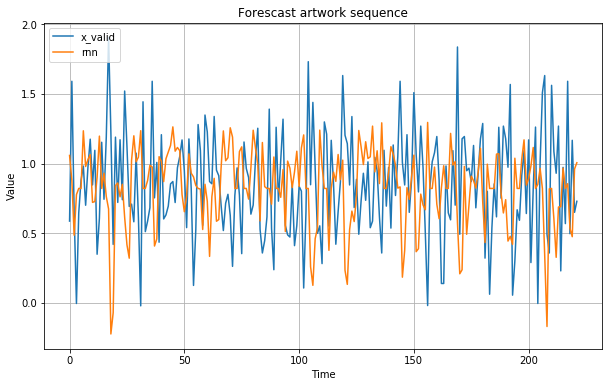

In [22]:
plot = plot_series(timeline, [(x_valid, 'x_valid'), (rnn_forecast, 'rnn')])
plot.title('Forescast artwork sequence')
plot.savefig(os.path.join(PLOT_PATH, 'forescast_sequence_2.png'))
plot.show()

**MAE**

In [23]:
df_evaluation['mae'].mean()

0.47065648118654885